# Research Project - Efficient Data Stream Anomaly Detection

<font color='rgba(255,255,0,0.5)'>Your task is to develop a Python script capable of detecting anomalies in a continuous data stream. This stream, simulating real-time sequences of floating-point numbers, could represent various metrics such as financial transactions or system metrics. Your focus will be on identifying unusual patterns, such as exceptionally high values or deviations from the norm. </font>

## 1) Algorithm Selection

<font color='rgba(255,255,0,0.5)'>Identify and implement a suitable algorithm for anomaly detection, capable of adapting to concept drift and seasonal variations.</font>

For this anomaly detection task, I have chosen three approaches:
 - Z-Score
 - Exponential Moving Average (EMA)
 - Long Short-Term Memory (LSTM)

#### Z-Score
The Z-Score is a simple statistical method that efficiently identifies outliers based on standard deviations from the mean. Its strength lies in its computational efficiency and simplicity, making it a great first-line approach, though it may struggle with non-stationary data or concept drift.

#### Exponential Moving Average
The EMA, on the other hand, adapts to changing data trends by giving more weight to recent observations, making it well-suited for time series with seasonality and trend shifts. However, its reliance on a predefined smoothing factor can be a limitation when adjusting to abrupt changes or anomalies that occur sporadically.

#### Long Short-Term Memory
Finally, the LSTM, a type of recurrent neural network, excels in handling long-term dependencies and temporal patterns, making it ideal for capturing complex trends and seasonal variations in the data stream. Its main downside is the higher computational cost and the need for a substantial amount of training data, which can make it less efficient for quick anomaly detection in smaller datasets. Combining these methods allows for a more robust and flexible detection system that can adapt to various data behaviors and anomalies.

## 2) Data Stream Simulation

<font color='rgba(255,255,0,0.5)'>Design a function to emulate a data stream, incorporating regular patterns, seasonal elements, and random noise. </font>

Number of anomalies: 46


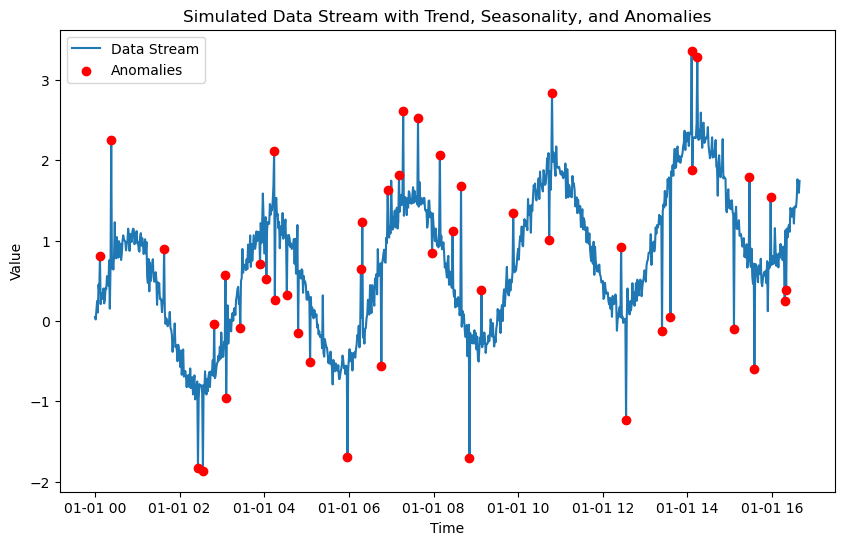

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_data_stream(n_points=1000, trend_type='linear', seasonality_period=50, noise_level=0.2, anomaly_noise_level=0.8, seed=42):
    # Create a time index (e.g., every minute)
    time = np.arange(n_points)
    
    # Generate trend component
    if trend_type == 'linear':
        # The curve grows linearly
        trend = np.linspace(0, 1, n_points)
    elif trend_type == 'exponential':
        # The curve grows exponentially
        trend = np.exp(np.linspace(0, 1, n_points)) - 1
    else:
        # The curve stays flat
        trend = np.zeros(n_points)
    
    # Generate seasonality component: I have chosen a sinusoidal seasonality component
    seasonality = np.sin(2 * np.pi * time / seasonality_period)
    
    # Set the seed to have always the same data stream
    np.random.seed(seed)

    # Generate random noise
    noise = np.random.normal(scale=noise_level, size=n_points,)

    # Generate noise to produce anomaly points (with a probability of 10%)
    anomaly_noise_probability = 0.9
    anomaly_noise = [x if np.random.rand() > anomaly_noise_probability else 0 for x in np.random.normal(scale=anomaly_noise_level, size=n_points)]

    # Let's consider the anomaly just if it is above an arbitrary threshold
    anomaly_threshold = 0.5
    anomaly_index = [1 if abs(x) > anomaly_threshold else 0 for x in anomaly_noise]

    # Combine trend, seasonality, noise and anomaly noise
    data_stream = trend + seasonality + noise + anomaly_noise
    
    # Create a pandas DataFrame with a timestamp column
    timestamps = pd.date_range(start="2024-01-01", periods=n_points, freq='min')  # 1-minute intervals
    df = pd.DataFrame({'timestamp': timestamps, 'value': data_stream, 'true_anomaly': anomaly_index})
    
    return df

data_stream = generate_data_stream(n_points=1000, trend_type='exponential', seasonality_period=200, noise_level=0.1, anomaly_noise_level=0.8)

# Plot the generated data stream
plt.figure(figsize=(10, 6))
plt.plot(data_stream['timestamp'], data_stream['value'], label='Data Stream')

# Plot anomalies in red
anomalies = data_stream[data_stream['true_anomaly'] == 1]
print(f'Number of anomalies: {len(anomalies)}')
plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies', zorder=5)

plt.title('Simulated Data Stream with Trend, Seasonality, and Anomalies')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


## 3) Anomaly Detection

<font color='rgba(255,255,0,0.5)'>Develop a real-time mechanism to accurately flag anomalies as the data is streamed.</font>

### Z-Score

In [109]:
from collections import deque

# DEQUE: list-like container with fast appends and pops on either end

# If maxlen is not specified or is None, deques may grow to an arbitrary length. 
# Otherwise, the deque is bounded to the specified maximum length. 
# Once a bounded length deque is full, when new items are added, 
# a corresponding number of items are discarded from the opposite end.

def detect_anomalies_z(data_stream, window_size=50, threshold=2.2):
    anomalies = []
    sliding_window = deque(maxlen=window_size)

    for i, data_point in enumerate(data_stream['value']):

        sliding_window.append(data_point)

        if len(sliding_window) == window_size:
            # Calculate Z-Score just when we have a window entirely filled with values
            mean = np.mean(sliding_window)
            std_dev = np.std(sliding_window)
            z_score = (data_point - mean) / std_dev

            if abs(z_score) > threshold:
                # Detect anomalies where z-score is greater than the threshold
                anomalies.append((1, data_point))
            else:
                anomalies.append((0, data_point))
        else:
            # We can't calculato Z-Score because the window is not entirely filled
            # so I consider the initial points as normal points
            anomalies.append((0, data_point))
    return [x[0] for x in anomalies]


In [110]:
z_anomaly_index = detect_anomalies_z(data_stream, 15)

In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def calculate_metrics(y_true, y_pred):
    print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'Precision: {precision_score(y_true, y_pred)}')
    print(f'Recall: {recall_score(y_true, y_pred)}')
    print(f'Number of anomalies detected: {np.sum(y_pred)}')

def plot_data_with_anomalies(data_stream, anomaly_index, ema_curve=False):
    plt.figure(figsize=(10, 6))
    plt.plot(data_stream['timestamp'], data_stream['value'], label='Data Stream')

    # Plot the EMA
    if (ema_curve):
        plt.plot(data_stream['timestamp'], data_stream['ema'], label='EMA', color='orange')

    # Highlight anomalies
    anomalies = data_stream[np.array(anomaly_index) == 1]
    plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies', zorder=5)

    plt.title('Data Stream with Detected Anomalies')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


In [112]:
calculate_metrics(data_stream['true_anomaly'], z_anomaly_index)

Accuracy: 0.971
Precision: 0.6440677966101694
Recall: 0.8260869565217391
Number of anomalies detected: 59


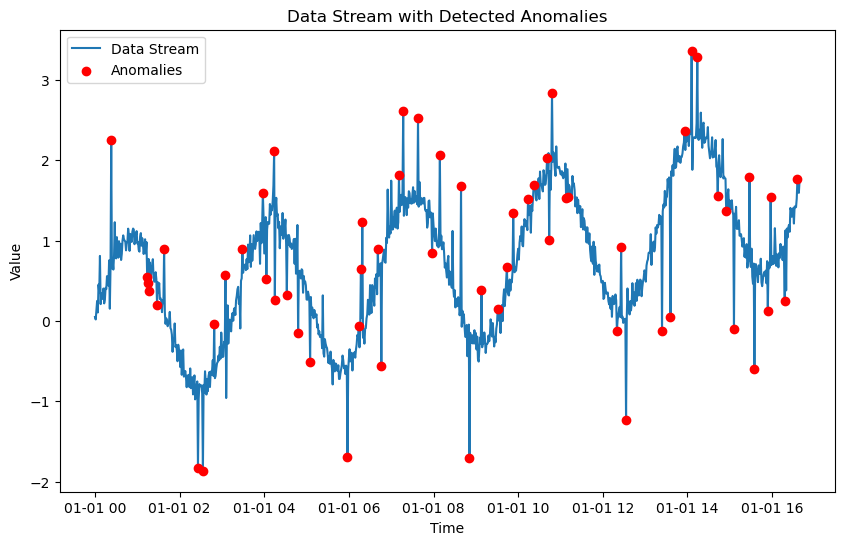

In [113]:
plot_data_with_anomalies(data_stream, z_anomaly_index, False)

### EMA

In [114]:
import numpy as np
import matplotlib.pyplot as plt

def detect_anomalies_ema(data_stream, span=50, threshold=1.0):
    # Calculate the EMA with the DataFrame method "ewm": Provide exponentially weighted (EW) calculations.
    data_stream['ema'] = data_stream['value'].ewm(span=span, adjust=False).mean()
    
    # Calculate the residual (difference between actual value and EMA)
    data_stream['residual'] = np.abs(data_stream['value'] - data_stream['ema'])
    
    # Detect anomalies where residual is greater than the threshold
    return np.where(data_stream['residual'] > threshold, 1, 0)


In [115]:
ema_anomalies = detect_anomalies_ema(data_stream, span=50, threshold=1.0)

In [116]:
calculate_metrics(data_stream['true_anomaly'], ema_anomalies)

Accuracy: 0.974
Precision: 0.9545454545454546
Recall: 0.45652173913043476
Number of anomalies detected: 22


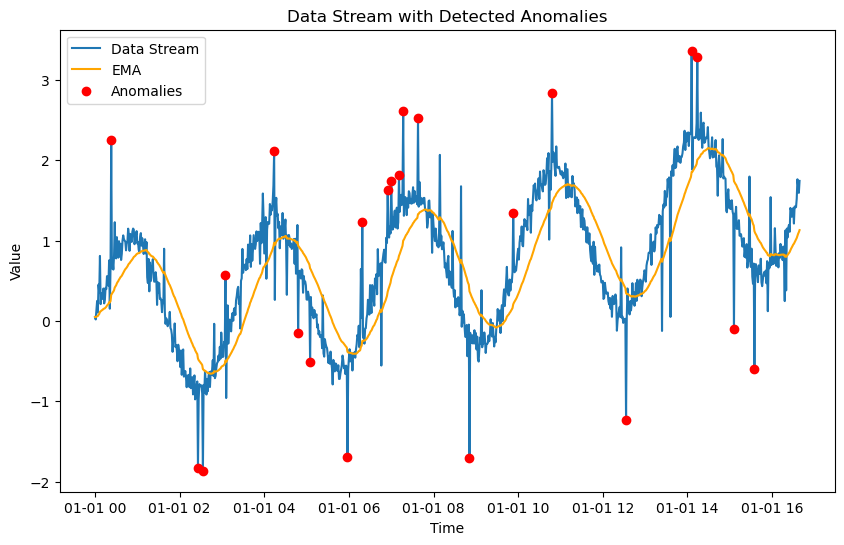

In [117]:
plot_data_with_anomalies(data_stream, ema_anomalies, True)

### LSTM

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

SEQ_LENGTH = 20

def create_lstm_model(input_shape, units=64):
    model = Sequential()
    model.add(LSTM(units, return_sequences=False, input_shape=input_shape)) # LSTM Layer
    model.add(Dense(1)) # Dense Layer for binary classification
    model.compile(optimizer='adam', loss='mse')
    return model

def detect_anomalies_lstm(data_stream=data_stream, units=64, seq_length=SEQ_LENGTH):

    model = create_lstm_model((seq_length, 1), units)

    errors = []  # Track reconstruction errors
    anomaly_flags = [] # Track anomalies

    # Normalize the data, because Neural Networks work better with normalized data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_stream['value'].values.reshape(-1, 1))

    # Initialize window with the first 'seq_length' data points
    window = data_scaled[:seq_length].reshape(1, seq_length, 1)

    for i in range(seq_length, len(data_scaled)):

        # The model simply uses the model's current state 
        # to make predictions on the input data 
        # (the window of past seq_length values).
        # 
        # the LSTM model is NOT trained. We could train it after every batch of data_points
        # (let's say: train the model every 50 data_points)
        # but that would be computationally really expensive.

        # Predict the next value
        predicted_value = model.predict(window, verbose=False)[0][0]
        actual_value = data_scaled[i][0]

        # Rescale the predicted and actual values
        predicted_value_rescaled = scaler.inverse_transform([[predicted_value]])[0][0]
        actual_value_rescaled = scaler.inverse_transform([[actual_value]])[0][0]

        # Calculate reconstruction error (absolute difference)
        error = abs(predicted_value_rescaled - actual_value_rescaled)
        errors.append(error)

        # Dynamic threshold: Detect anomalies based on moving average of errors
        if len(errors) > SEQ_LENGTH:
            threshold = np.mean(errors[-SEQ_LENGTH:]) + 2 * np.std(errors[-SEQ_LENGTH:])
        else:
            threshold = np.mean(errors) + 2 * np.std(errors)

        is_anomaly = error > threshold
        anomaly_flags.append(is_anomaly)

        # slide the window with the new actual value
        new_data_point = data_scaled[i].reshape(1, 1, 1)
        window = np.append(window[:, 1:, :], new_data_point, axis=1)

    # add zeros (no-anomaly) to first elements and transform Boolean in 0/1
    lstm_predicted = np.concatenate((np.zeros(seq_length).tolist(), [1 if x else 0 for x in np.array(anomaly_flags)]))

    return lstm_predicted


/Users/maurorusso/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Accuracy: 0.955
Precision: 0.5142857142857142
Recall: 0.391304347826087
Number of anomalies detected: 35.0


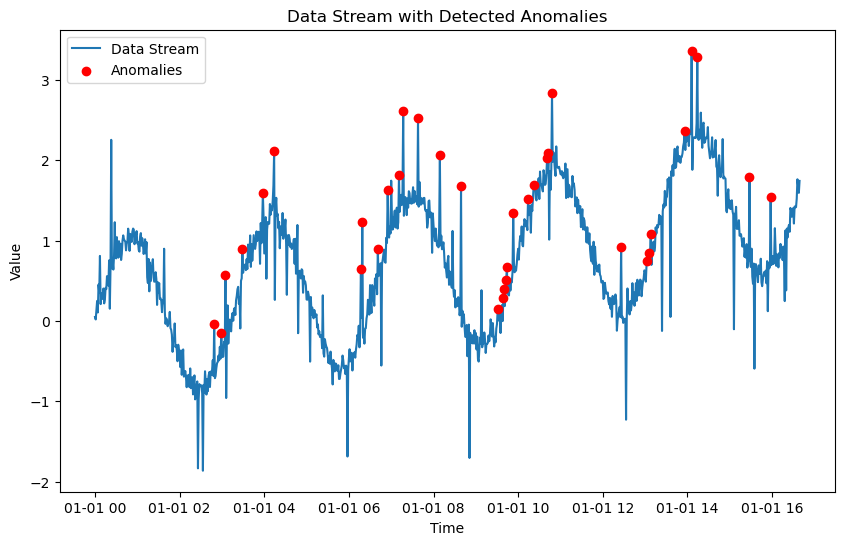

In [119]:
# Run the real-time anomaly detection simulation
lstm_predicted = detect_anomalies_lstm()

calculate_metrics(data_stream['true_anomaly'], lstm_predicted)

plot_data_with_anomalies(data_stream, lstm_predicted, False)

## 4) Optimization

<font color='rgba(255,255,0,0.5)'>Ensure the algorithm is optimized for both speed and efficiency.</font>

Anomalies often indicate critical issues, and delays in detection could lead to significant consequences. Therefore, I chose to prioritize recall because, in this case, it is vital to correctly identify as many true anomalies as possible. 

High recall ensures that the model minimizes false negatives, which is essential when the cost of missing an anomaly is higher than identifying false positives. In a context of gas distribution, an anomaly could be a gas loss, which translates in money loss and we can not let this happen.

To further improve the model's performance, I applied GridSearch to my approaches, allowing me to systematically explore a range of parameters and identify the best configuration for the anomaly detection task. This ensures that the model is not only accurate but also tuned for optimal performance.

Better results could be obtained with more dataset samples. To not make this longer than it is, we are going to use just one dataset, the one we used so far.

### Z-Score

In [120]:
from sklearn.metrics import recall_score

def custom_recall_score_z(params, data_stream):
    window_size = params['window_size']
    threshold = params['threshold']
    
    predicted_anomalies = detect_anomalies_z(data_stream, window_size, threshold)
    
    return recall_score(data_stream['true_anomaly'], predicted_anomalies)

# GridSearch setup
def optimize_hyperparameters_z(data_stream):
    param_grid = {
        'window_size': [10, 15, 20, 30, 50, 70],
        'threshold': [1.5, 1.75, 2.0, 2.25, 2.5] 
    }

    best_params = None
    best_score = -1

    # Perform grid search among all possible params combination
    for window_size in param_grid['window_size']:
        for threshold in param_grid['threshold']:
            params = { 'window_size': window_size, 'threshold': threshold }
            recall = custom_recall_score_z(params, data_stream)
            
            if recall > best_score:
                best_score = recall
                best_params = params

    return best_params, best_score

In [121]:
best_params, best_score = optimize_hyperparameters_z(data_stream)
print("Best parameters:", best_params)
print("Best recall score:", best_score)

Best parameters: {'window_size': 10, 'threshold': 1.5}
Best recall score: 0.9565217391304348


### EMA

In [122]:
from sklearn.metrics import recall_score

def custom_recall_score_ema(params, data_stream):
    span = params['span']
    threshold = params['threshold']
    
    predicted_anomalies = detect_anomalies_ema(data_stream, span, threshold)
    
    return recall_score(data_stream['true_anomaly'], predicted_anomalies)

# GridSearch setup
def optimize_hyperparameters_ema(data_stream):
    param_grid = {
        'span': [10, 15, 20, 30, 50, 70],
        'threshold': [0.5, 1.0, 1.5, 2.0, 2.25, 2.5] 
    }

    best_params = None
    best_score = -1

    # Perform grid search among all possible params combination
    for span in param_grid['span']:
        for threshold in param_grid['threshold']:
            params = { 'span': span, 'threshold': threshold }
            recall = custom_recall_score_ema(params, data_stream)
            
            if recall > best_score:
                best_score = recall
                best_params = params

    return best_params, best_score

In [123]:
best_params, best_score = optimize_hyperparameters_ema(data_stream)
print("Best parameters:", best_params)
print("Best recall score:", best_score)

Best parameters: {'span': 20, 'threshold': 0.5}
Best recall score: 0.8478260869565217


### LSTM

In [124]:
from sklearn.metrics import recall_score

def custom_recall_score_lstm(params, data_stream):
    n_units = params['n_units']
    seq_length = params['seq_length']
    
    predicted_anomalies = detect_anomalies_lstm(data_stream, n_units, seq_length)
    
    return recall_score(data_stream['true_anomaly'], predicted_anomalies)

# GridSearch setup
def optimize_hyperparameters_lstm(data_stream):
    param_grid = {
        'n_units': [16, 32, 64],
        'seq_length': [10, 20, 30, 40]
    }

    best_params = None
    best_score = -1

    # Perform grid search among all possible params combination
    for n_units in param_grid['n_units']:
        for seq_length in param_grid['seq_length']:
            params = { 'n_units': n_units, 'seq_length': seq_length }
            recall = custom_recall_score_lstm(params, data_stream)
            
            if recall > best_score:
                best_score = recall
                best_params = params

    return best_params, best_score

In [ ]:
best_params, best_score = optimize_hyperparameters_lstm(data_stream)
# this takes up to 15 minutes

In [470]:
print("Best parameters:", best_params)
print("Best recall score:", best_score)

Best parameters: {'n_units': 32, 'seq_length': 10}
Best recall score: 0.43478260869565216


### Conclusions

Results:
 - Z-Score: 0.9565
 - EMA: 0.8478
 - LSTM: 0.4347

The choice is: Z-Score 

with window_size = 10 and threshold = 1.5

## 5) Visualization

<font color='rgba(255,255,0,0.5)'>Create a straightforward real-time visualization tool to display both the data stream and any detected anomalies.</font>

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import time

def real_time_plot(data_stream, anomaly_index):
    plt.clf()  # Clear the current figure
    plt.figure(figsize=(10, 6))
    
    # Plot the data stream
    plt.plot(data_stream['timestamp'], data_stream['value'], label='Data Stream')
    
    # Highlight anomalies
    anomalies = data_stream[np.array(anomaly_index) == 1]
    plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies', zorder=5)

    plt.title('Data Stream with Detected Anomalies')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    plt.pause(0.5)  # Pause to allow the plot to update
    plt.draw()

In [126]:
# Main loop for updating the plot
ENABLED = False
if (ENABLED):
    for i in range(2, len(data_stream)):
        # the "[:i]"" simulates the step-by-step data points arrival
        z_anomalies_index = detect_anomalies_z(data_stream=data_stream[:i], window_size=10, threshold=1.5)
        real_time_plot(data_stream[:i], z_anomalies_index[:i])
        time.sleep(0.5) # Sleep for 0.5 seconds between frames

    plt.show()

# This will print a different plot every second, simulating that a new data point arrives every second.
# To avoid a notebook with 1000 plots, I skipped the execution.

### Test

Accuracy: 0.856
Precision: 0.20930232558139536
Recall: 0.8181818181818182
Number of anomalies detected: 172


<Figure size 640x480 with 0 Axes>

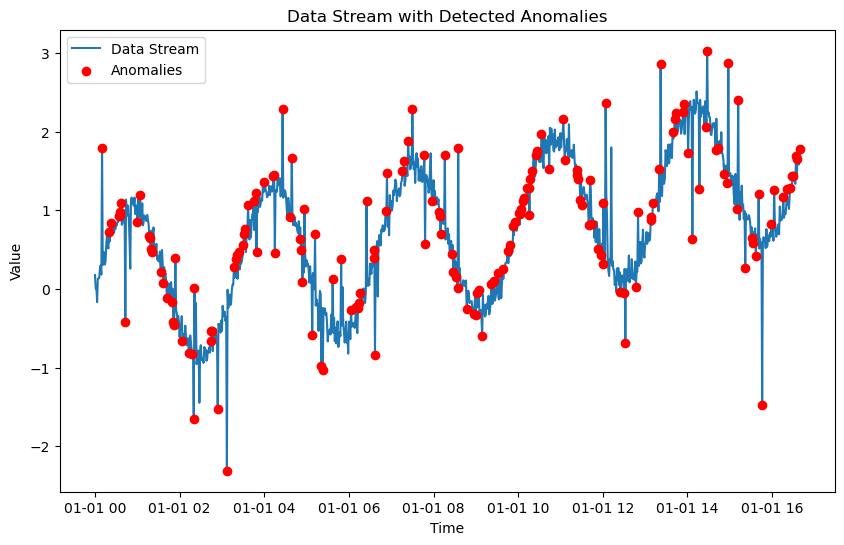

<Figure size 640x480 with 0 Axes>

In [127]:
# Just change the seed to obtain a similar but different dataset
test_data_stream = generate_data_stream(n_points=1000, trend_type='exponential', seasonality_period=200, noise_level=0.1, anomaly_noise_level=0.8, seed=11)

test_anomalies = detect_anomalies_z(data_stream=test_data_stream, window_size=10, threshold=1.5)
    
calculate_metrics(test_data_stream['true_anomaly'], test_anomalies)
real_time_plot(test_data_stream, test_anomalies)

We have detected a lot of anomalies, most of them are not true anomalies, but this way we have more chances to not miss true anomalies and so to not lose money :)

<i>Mauro Russo</i>